In [27]:
import os
import zipfile
import urllib.request

In [28]:
url = "https://github.com/garythung/trashnet/archive/refs/heads/master.zip"
zip_path = "trashnet.zip"

In [29]:
print("Downloading... This may take a minute.")
urllib.request.urlretrieve(url, zip_path)

print("Extracting files...")
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall()

os.remove(zip_path)

print("\nExtracting dataset images...")
dataset_zip = None

Downloading... This may take a minute.
Extracting files...

Extracting dataset images...


In [30]:
if os.path.exists('trashnet-master/data/dataset-resized.zip'):
    dataset_zip = 'trashnet-master/data/dataset-resized.zip'
    base_path = 'trashnet-master/data'
elif os.path.exists('trashnet/data/dataset-resized.zip'):
    dataset_zip = 'trashnet/data/dataset-resized.zip'
    base_path = 'trashnet/data'

if dataset_zip:
    print(f"Found dataset zip at: {dataset_zip}")
    with zipfile.ZipFile(dataset_zip, 'r') as zip_ref:
        zip_ref.extractall(base_path)
    print("✅ Dataset extracted successfully!")

    # Remove the zip file to save space
    os.remove(dataset_zip)

    DATA_PATH = os.path.join(base_path, 'dataset-resized')
else:
    print("Error: dataset-resized.zip not found!")
    !ls -R | grep dataset

print(f"\n✅ Dataset ready!")
print(f"Dataset path: {DATA_PATH}\n")

Found dataset zip at: trashnet-master/data/dataset-resized.zip
✅ Dataset extracted successfully!

✅ Dataset ready!
Dataset path: trashnet-master/data/dataset-resized



In [31]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import MobileNetV2, EfficientNetB3, ResNet50V2, InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers.schedules import CosineDecay
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [32]:
print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [33]:
IMG_SIZE = 299
BATCH_SIZE = 32
EPOCHS = 30
NUM_CLASSES = 6
DATA_PATH = 'trashnet-master/data/dataset-resized'

In [34]:
if not os.path.exists(DATA_PATH):
    print(f"❌ Error: Dataset not found at {DATA_PATH}")
    print("Please run the dataset download code first!")
else:
    print(f"✅ Dataset found at {DATA_PATH}")

✅ Dataset found at trashnet-master/data/dataset-resized


In [35]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest',
    validation_split=0.2  # 80-20 split
)

In [36]:
test_datagen = ImageDataGenerator(
    rescale=1./255
)

In [37]:
print("\nLoading training data...")
train_generator = train_datagen.flow_from_directory(
    DATA_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)


Loading training data...
Found 2024 images belonging to 6 classes.


In [38]:
print("Loading validation data...")
validation_generator = train_datagen.flow_from_directory(
    DATA_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Loading validation data...
Found 503 images belonging to 6 classes.


In [39]:
class_names = list(train_generator.class_indices.keys())
print("\n" + "="*70)
print("DATASET INFORMATION")
print("="*70)
print(f"Classes: {class_names}")
print(f"Number of training images: {train_generator.samples}")
print(f"Number of validation images: {validation_generator.samples}")
print(f"Number of classes: {len(class_names)}")


DATASET INFORMATION
Classes: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
Number of training images: 2024
Number of validation images: 503
Number of classes: 6



Displaying sample images...


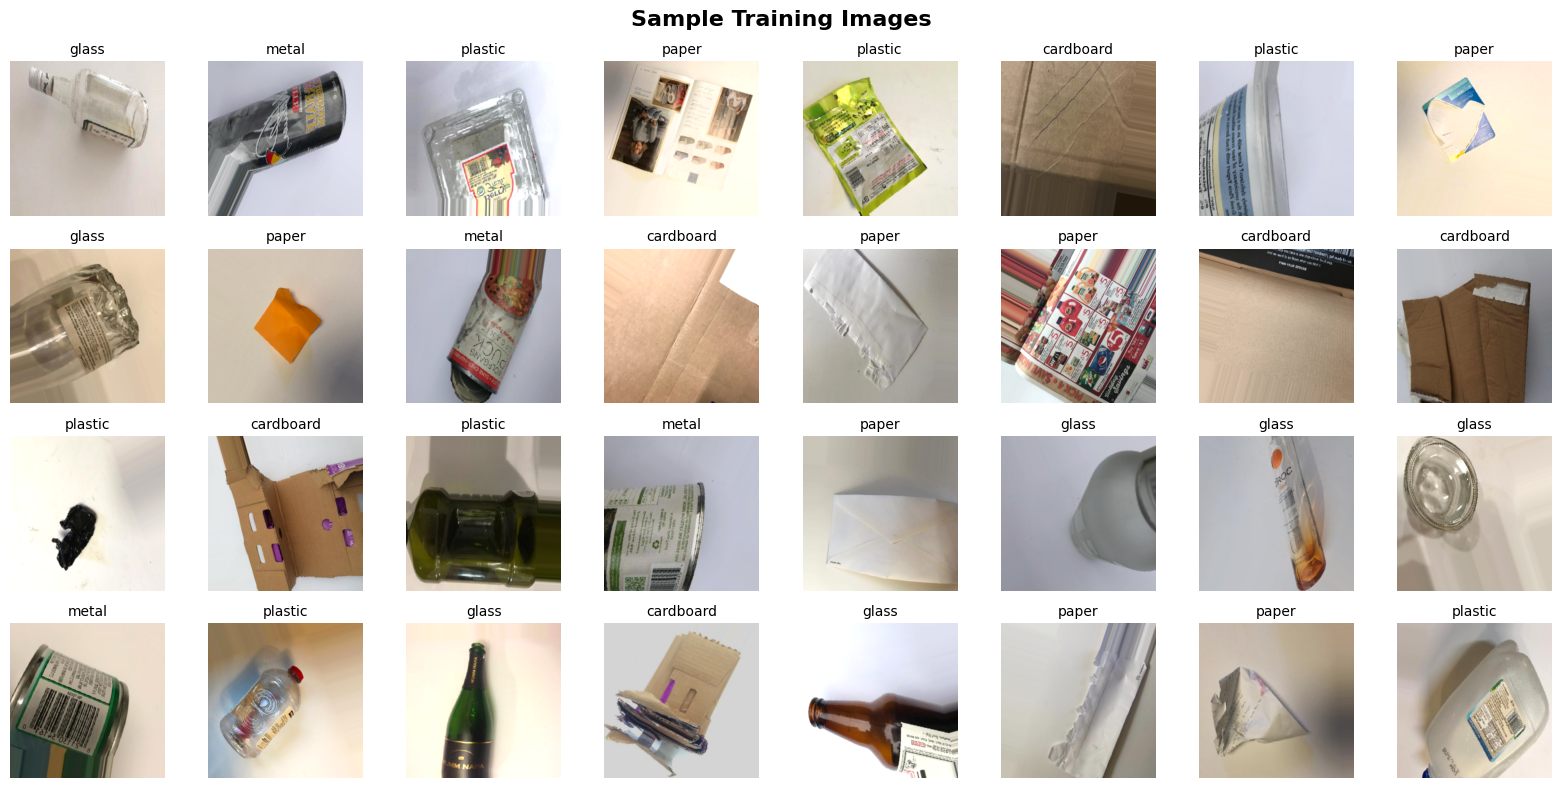

In [40]:
def show_batch(generator):
    """Display a batch of images with labels"""
    x_batch, y_batch = next(generator)

    fig, axes = plt.subplots(4, 8, figsize=(16, 8))
    fig.suptitle('Sample Training Images', fontsize=16, fontweight='bold')

    for i, ax in enumerate(axes.flat):
        if i < len(x_batch):
            ax.imshow(x_batch[i])
            label_idx = np.argmax(y_batch[i])
            ax.set_title(class_names[label_idx], fontsize=10)
            ax.axis('off')

    plt.tight_layout()
    plt.show()

print("\nDisplaying sample images...")
show_batch(train_generator)

In [41]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

/tmp/ipython-input-293992469.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))


In [42]:
base_model.trainable = False

In [43]:
inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model(inputs, training=False)

In [44]:
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)

x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)

x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.3)(x)

In [45]:
outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)

In [46]:
model = keras.Model(inputs, outputs)

In [47]:
lr_schedule_phase1 = CosineDecay(
    initial_learning_rate=0.001,
    decay_steps=train_generator.samples // BATCH_SIZE * 15  # 15 epochs
)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule_phase1),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [48]:
print("\nModel Architecture:")
model.summary()


Model Architecture:


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 10, 10, 1280)   │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,625,734 (10.02 MB)

 Trainable params: 364,678 (1.39 MB)

 Non-trainable params: 2,261,056 (8.63 MB)

In [49]:
print(f"\nBase Model Layers: {len(base_model.layers)}")
print(f"Trainable: {base_model.trainable}")


Base Model Layers: 154
Trainable: False


In [50]:
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),
    keras.callbacks.ModelCheckpoint(
        'best_waste_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

In [51]:
history_phase1 = model.fit(
    train_generator,
    epochs=15,
    validation_data=validation_generator,
    callbacks=callbacks,
    verbose=1
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 831ms/step - accuracy: 0.4104 - loss: 1.7213
Epoch 1: val_accuracy improved from -inf to 0.67396, saving model to best_waste_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 90s 1s/step - accuracy: 0.4124 - loss: 1.7156 - val_accuracy: 0.6740 - val_loss: 0.9484 - learning_rate: 9.8873e-04
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 729ms/step - accuracy: 0.6943 - loss: 0.8607
Epoch 2: val_accuracy improved from 0.67396 to 0.70974, saving model to best_waste_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 58s 917ms/step - accuracy: 0.6945 - loss: 0.8607 - val_accuracy: 0.7097 - val_loss: 0.7906 - learning_rate: 9.5541e-04
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 724ms/step - accuracy: 0.7371 - loss: 0.7779
Epoch 3: val_accuracy improved from 0.70974 to 0.72167, saving model to best_waste_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 58s 911ms/step - accuracy: 0.7370 - loss: 0.7781 - val_accuracy: 0.7217 - val_loss: 0.7184 - learning_rate: 9.0156e-04
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 708ms/step - accuracy: 0.7646 - loss: 0.6644
Epoch 4: val_accuracy improved from 0.72167 to 0.74155, saving model to best_waste_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 57s 896ms/step - accuracy: 0.7646 - loss: 0.6645 - val_accuracy: 0.7416 - val_loss: 0.6776 - learning_rate: 8.2959e-04
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 716ms/step - accuracy: 0.7698 - loss: 0.6685
Epoch 5: val_accuracy did not improve from 0.74155
64/64 ━━━━━━━━━━━━━━━━━━━━ 58s 900ms/step - accuracy: 0.7699 - loss: 0.6681 - val_accuracy: 0.7177 - val_loss: 0.7113 - learning_rate: 7.4277e-04
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 723ms/step - accuracy: 0.7775 - loss: 0.6071
Epoch 6: val_accuracy did not improve from 0.74155
64/64 ━━━━━━━━━━━━━━━━━━━━ 58s 907ms/step - accuracy: 0.7773 - loss: 0.6077 - val_accuracy: 0.7197 - val_loss: 0.7304 - learning_rate: 6.4499e-04
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 721ms/step - accuracy: 0.7938 - loss: 0.5854
Epoch 7: val_accuracy did not improve from 0.74155
64/64 ━━━━━━━━━━━━━━━━━━━━ 58s 907ms/step - accuracy: 0.7937 - loss: 0.5855 - val_accuracy: 0.7396 - val_loss: 0.6541 - learning_rate: 5.4068e-04
Epoch

64/64 ━━━━━━━━━━━━━━━━━━━━ 57s 893ms/step - accuracy: 0.8118 - loss: 0.5534 - val_accuracy: 0.7654 - val_loss: 0.6363 - learning_rate: 4.3453e-04
Epoch 9/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 734ms/step - accuracy: 0.7995 - loss: 0.5503
Epoch 9: val_accuracy did not improve from 0.76541
64/64 ━━━━━━━━━━━━━━━━━━━━ 58s 918ms/step - accuracy: 0.7997 - loss: 0.5498 - val_accuracy: 0.7475 - val_loss: 0.6326 - learning_rate: 3.3133e-04
Epoch 10/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 723ms/step - accuracy: 0.8155 - loss: 0.5061
Epoch 10: val_accuracy improved from 0.76541 to 0.77535, saving model to best_waste_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 58s 912ms/step - accuracy: 0.8155 - loss: 0.5062 - val_accuracy: 0.7753 - val_loss: 0.6226 - learning_rate: 2.3575e-04
Epoch 11/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 724ms/step - accuracy: 0.8096 - loss: 0.5256
Epoch 11: val_accuracy did not improve from 0.77535
64/64 ━━━━━━━━━━━━━━━━━━━━ 58s 903ms/step - accuracy: 0.8099 - loss: 0.5253 - val_accuracy: 0.7535 - val_loss: 0.6600 - learning_rate: 1.5207e-04
Epoch 12/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 711ms/step - accuracy: 0.8233 - loss: 0.5305
Epoch 12: val_accuracy did not improve from 0.77535
64/64 ━━━━━━━━━━━━━━━━━━━━ 57s 891ms/step - accuracy: 0.8234 - loss: 0.5300 - val_accuracy: 0.7594 - val_loss: 0.6309 - learning_rate: 8.4092e-05
Epoch 13/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 721ms/step - accuracy: 0.8197 - loss: 0.4850
Epoch 13: val_accuracy did not improve from 0.77535
64/64 ━━━━━━━━━━━━━━━━━━━━ 58s 903ms/step - accuracy: 0.8199 - loss: 0.4846 - val_accuracy: 0.7694 - val_loss: 0.6383 - learning_rate: 3.4867e-05

In [52]:
base_model.trainable = True

In [53]:
fine_tune_at = int(len(base_model.layers) * 0.7)

In [54]:
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

In [55]:
print(f"Fine-tuning from layer {fine_tune_at}/{len(base_model.layers)}")
print(f"Trainable layers: {len(base_model.layers) - fine_tune_at}")

Fine-tuning from layer 107/154
Trainable layers: 47


In [58]:
lr_schedule_phase2 = CosineDecay(
    initial_learning_rate=0.0001,  # Lower starting point
    decay_steps=train_generator.samples // BATCH_SIZE * EPOCHS  # Remaining epochs
)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001), # Use a fixed learning rate here
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [59]:
history_phase2 = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=callbacks,
    initial_epoch=history_phase1.epoch[-1],
    verbose=1
)

Epoch 15/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 906ms/step - accuracy: 0.9036 - loss: 0.2799
Epoch 15: val_accuracy did not improve from 0.77535
64/64 ━━━━━━━━━━━━━━━━━━━━ 105s 1s/step - accuracy: 0.9035 - loss: 0.2801 - val_accuracy: 0.6819 - val_loss: 1.2332 - learning_rate: 1.0000e-04
Epoch 16/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 759ms/step - accuracy: 0.9223 - loss: 0.2377
Epoch 16: val_accuracy did not improve from 0.77535
64/64 ━━━━━━━━━━━━━━━━━━━━ 61s 942ms/step - accuracy: 0.9223 - loss: 0.2375 - val_accuracy: 0.5527 - val_loss: 1.9758 - learning_rate: 1.0000e-04
Epoch 17/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 733ms/step - accuracy: 0.9295 - loss: 0.2060
Epoch 17: val_accuracy did not improve from 0.77535
64/64 ━━━━━━━━━━━━━━━━━━━━ 59s 922ms/step - accuracy: 0.9294 - loss: 0.2061 - val_accuracy: 0.6322 - val_loss: 1.4851 - learning_rate: 1.0000e-04
Epoch 18/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 760ms/step - accuracy: 0.9465 - loss: 0.1636
Epoch 18: val_accuracy did not improve from 0.77535
64/64 ━━

In [60]:
history = {
    'accuracy': history_phase1.history['accuracy'] + history_phase2.history['accuracy'],
    'val_accuracy': history_phase1.history['val_accuracy'] + history_phase2.history['val_accuracy'],
    'loss': history_phase1.history['loss'] + history_phase2.history['loss'],
    'val_loss': history_phase1.history['val_loss'] + history_phase2.history['val_loss']
}

history

{'accuracy': [0.5385375618934631,
  0.7030632495880127,
  0.7292490005493164,
  0.7697628736495972,
  0.77173912525177,
  0.7697628736495972,
  0.7885375618934631,
  0.8033596873283386,
  0.8083003759384155,
  0.820652186870575,
  0.8241106867790222,
  0.8295454382896423,
  0.8349802494049072,
  0.8275691866874695,
  0.823616623878479,
  0.8992094993591309,
  0.9249011874198914,
  0.9229248762130737,
  0.9337944388389587,
  0.9392292499542236,
  0.9466403126716614,
  0.9530632495880127,
  0.9436758756637573,
  0.9525691866874695,
  0.95652174949646,
  0.9634387493133545,
  0.9614624381065369,
  0.9654150009155273,
  0.9584980010986328,
  0.9614624381065369,
  0.9767786264419556],
 'val_accuracy': [0.6739562749862671,
  0.7097415328025818,
  0.7216699719429016,
  0.7415506839752197,
  0.7176938652992249,
  0.7196819186210632,
  0.7395626306533813,
  0.7654075622558594,
  0.7475149035453796,
  0.775347888469696,
  0.7534791231155396,
  0.7594433426856995,
  0.7693836688995361,
  0.765407

In [61]:
def plot_history(history, phase1_epochs):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

    epochs_range = range(len(history['accuracy']))

    # Accuracy
    ax1.plot(epochs_range, history['accuracy'], 'b-', label='Train Accuracy', linewidth=2)
    ax1.plot(epochs_range, history['val_accuracy'], 'r-', label='Val Accuracy', linewidth=2)
    ax1.axvline(x=phase1_epochs, color='green', linestyle='--',
                label='Fine-tuning Start', linewidth=2)
    ax1.set_title('Model Accuracy', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Accuracy', fontsize=12)
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)

    # Loss
    ax2.plot(epochs_range, history['loss'], 'b-', label='Train Loss', linewidth=2)
    ax2.plot(epochs_range, history['val_loss'], 'r-', label='Val Loss', linewidth=2)
    ax2.axvline(x=phase1_epochs, color='green', linestyle='--',
                label='Fine-tuning Start', linewidth=2)
    ax2.set_title('Model Loss', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Loss', fontsize=12)
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
    plt.show()

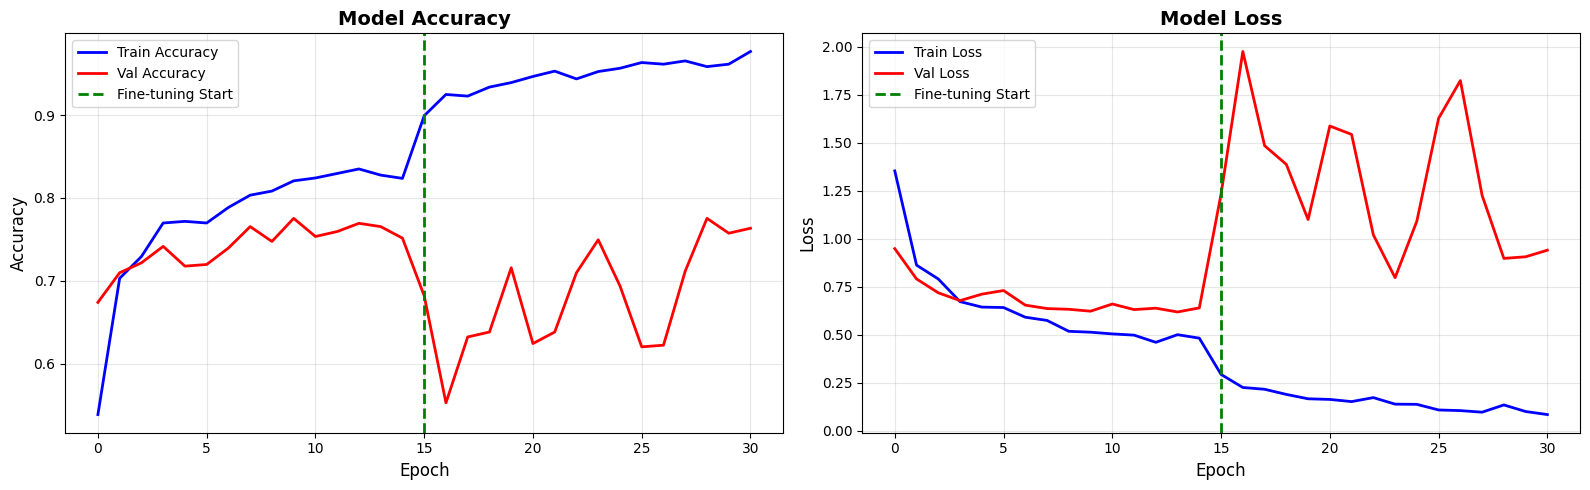

In [62]:
plot_history(history, len(history_phase1.history['accuracy']))

In [63]:
model = keras.models.load_model('best_waste_model.h5')

In [64]:
val_loss, val_accuracy = model.evaluate(validation_generator, verbose=1)
print(f"\n✅ Validation Loss: {val_loss:.4f}")
print(f"✅ Validation Accuracy: {val_accuracy:.4f} ({val_accuracy*100:.2f}%)")

16/16 ━━━━━━━━━━━━━━━━━━━━ 22s 998ms/step - accuracy: 0.8042 - loss: 0.5849

✅ Validation Loss: 0.6098
✅ Validation Accuracy: 0.7793 (77.93%)


In [65]:
print("\nGenerating predictions...")
validation_generator.reset()
y_pred = model.predict(validation_generator, steps=len(validation_generator), verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = validation_generator.classes


Generating predictions...
16/16 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step


              precision    recall  f1-score   support

   cardboard     0.9355    0.7250    0.8169        80
       glass     0.6508    0.8200    0.7257       100
       metal     0.7640    0.8293    0.7953        82
       paper     0.7985    0.9068    0.8492       118
     plastic     0.8382    0.5938    0.6951        96
       trash     0.5833    0.5185    0.5490        27

    accuracy                         0.7674       503
   macro avg     0.7617    0.7322    0.7385       503
weighted avg     0.7813    0.7674    0.7652       503



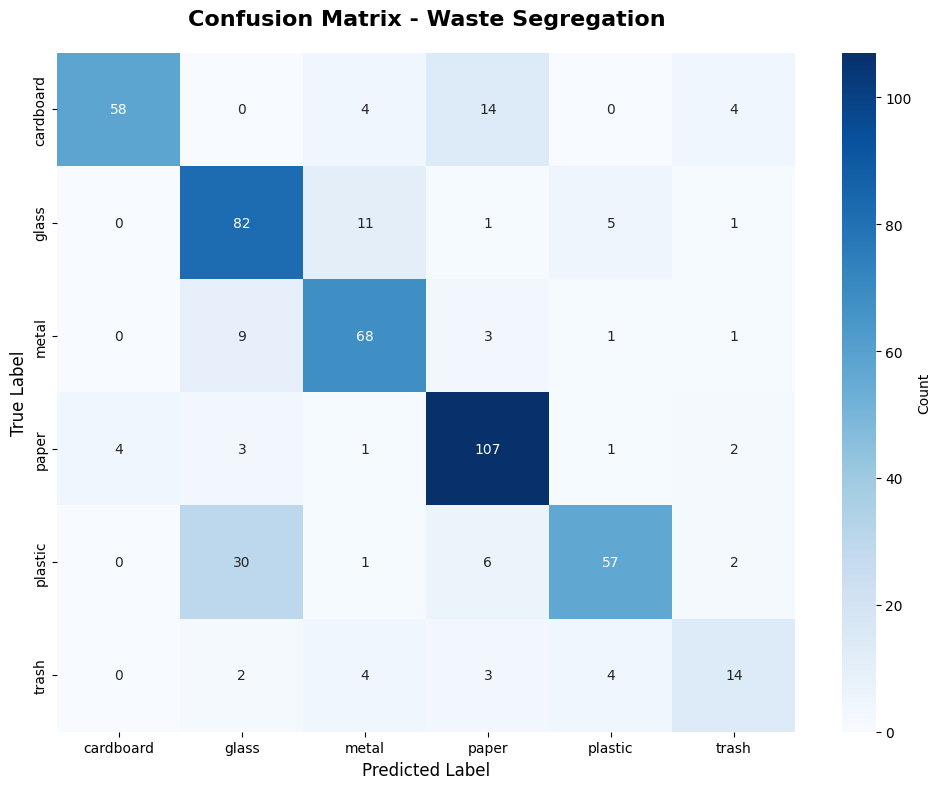

In [80]:
print(classification_report(y_true, y_pred_classes, target_names=class_names, digits=4))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Waste Segregation', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

In [79]:
class_accuracy = cm.diagonal() / cm.sum(axis=1)
for i, class_name in enumerate(class_names):
    print(f"{class_name:12s}: {class_accuracy[i]*100:.2f}%")

cardboard   : 72.50%
glass       : 82.00%
metal       : 82.93%
paper       : 90.68%
plastic     : 59.38%
trash       : 51.85%


In [68]:
def predict_waste(img_path, show_top_k=3):
    """Predict waste type from image"""
    img = keras.preprocessing.image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    predictions = model.predict(img_array, verbose=0)

    print(f"\nTop {show_top_k} Predictions:")
    print("-" * 40)
    top_k_idx = np.argsort(predictions[0])[::-1][:show_top_k]

    for i, idx in enumerate(top_k_idx, 1):
        print(f"{i}. {class_names[idx]:12s}: {predictions[0][idx]*100:.2f}%")

    # Display
    predicted_class = class_names[np.argmax(predictions)]
    confidence = np.max(predictions) * 100

    plt.figure(figsize=(8, 6))
    plt.imshow(img)
    plt.title(f"Prediction: {predicted_class} ({confidence:.2f}%)",
              fontsize=14, fontweight='bold', pad=15)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    return predicted_class, confidence

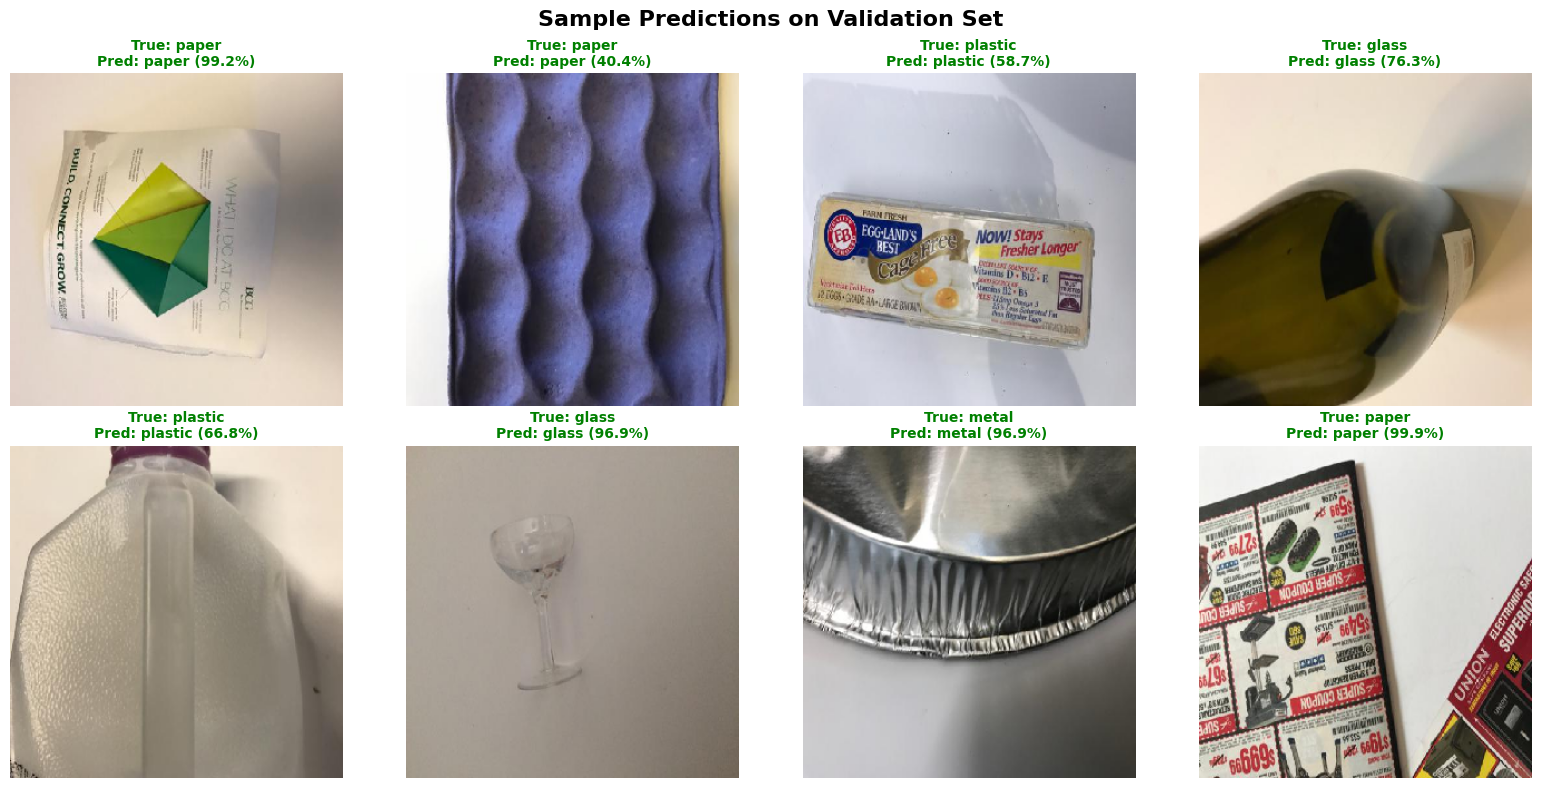

In [77]:
import random

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
fig.suptitle('Sample Predictions on Validation Set', fontsize=16, fontweight='bold')

for i, ax in enumerate(axes.flat):
    # Get random image from validation
    random_idx = random.randint(0, len(validation_generator.filenames) - 1)
    img_path = os.path.join(DATA_PATH, validation_generator.filenames[random_idx])

    # Load and predict
    img = keras.preprocessing.image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    img_array = keras.preprocessing.image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    pred = model.predict(img_array, verbose=0)
    pred_class = class_names[np.argmax(pred)]
    confidence = np.max(pred) * 100

    true_class = validation_generator.filenames[random_idx].split('/')[0]

    # Display
    ax.imshow(img)
    color = 'green' if pred_class == true_class else 'red'
    ax.set_title(f"True: {true_class}\nPred: {pred_class} ({confidence:.1f}%)",
                 fontsize=10, color=color, fontweight='bold')
    ax.axis('off')

plt.tight_layout()
plt.savefig('sample_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

In [78]:
print(f"✅ Final Validation Accuracy: {val_accuracy*100:.2f}%")

✅ Final Validation Accuracy: 77.93%
